In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import argparse
import copy
import sys
import time

import numpy as np

from sklearn.metrics import mean_absolute_error

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [5]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

In [6]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# 1. Pre-Processing

In this step, smiles data is read from the ZINC.smiles file and converted to pytorch Dataset which contains onehot tensor, list of sequence lengths and logP value of each molecules.

There are two ways to handle the input sequences of RNN. First is making every sequence lengths to be the same with zero-padding. Second is let RNN to handle sequences of dynamic length by generating __packed sequence object__.

At first, __packed sequence object__ was generated in the __forward function__ of RNN blocks. However, pytorch did not train the module with GPU in this way. The problem was solved by using a custom __collate function of DataLoader__. A collate function allows us to do custom operation to the batch before the batch returned to the model as input. Generating packed sequence with collate function made pytorch to train the modle with GPU.

In [7]:
def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()

    smi_list = []
    logP_list = []

    for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))

    logP_list = np.asarray(logP_list).astype(float)

    return smi_list, logP_list

def smiles_to_onehot(list_smiles):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles) < max_length:
            smiles += " "
        vector = [vocab.index(str(x)) for x in smiles]
        onehot = np.zeros((max_length, len(vocab)), dtype=float)
        for i, elm in enumerate(vector):
            onehot[i][elm] = 1.0
        return onehot

    vocab = np.load('./vocab.npy')
    onehot_total = list()
    length_total = list()
    for smiles in tqdm_notebook(list_smiles, desc='Converting Data'):
        onehot = smiles_to_vector(smiles, list(vocab), 120)
        onehot_total.append(onehot)
        length_total.append(len(smiles))
    
    return np.asarray(onehot_total), np.asarray(length_total)

In [47]:
class RNNDataset(Dataset):

    def __init__(self, list_smiles, list_length, list_logP):
        self.list_smiles = list_smiles
        self.list_length = list_length
        self.list_logP = list_logP

    def __len__(self):
        return len(self.list_smiles)

    def __getitem__(self, index):
        return self.list_smiles[index], self.list_length[index], self.list_logP[index]
    
    
def pad_packed_collate(batch):
    # [batch_size, 3(onehot, length, logP)]
    sorted_batch = sorted(batch, key=lambda x: x[1], reverse=True)
    batch_onehot  = list()
    batch_length = list()
    batch_logP = list()
    for onehot, length, logP in sorted_batch:
        batch_onehot.append(onehot)
        batch_length.append(length)
        batch_logP.append(logP)
    batch_onehot = torch.Tensor(batch_onehot)
    batch_length = torch.Tensor(batch_length).int()
    batch_logP = torch.Tensor(batch_logP)
    packed_batch = nn.utils.rnn.pack_padded_sequence(batch_onehot, batch_length, batch_first=True)
    return packed_batch, batch_logP
    
def partition(list_onehot, list_length, list_logP, args):
    num_total = list_onehot.shape[0]
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)
    num_train = num_total - (num_val + num_test)

    onehot_train = list_onehot[:num_train]
    length_train = list_length[:num_train]
    logP_trian = list_logP[:num_train]

    onehot_val = list_onehot[num_train:num_train+num_val]
    length_val = list_length[num_train:num_train+num_val]
    logP_val = list_logP[num_train:num_train+num_val]

    onehot_test = list_onehot[num_total-num_test:]
    length_test = list_length[num_total-num_test:]
    logP_test = list_logP[num_total-num_test:]

    train_set = RNNDataset(onehot_train, length_train, logP_trian)
    val_set = RNNDataset(onehot_val, length_val, logP_val)
    test_set = RNNDataset(onehot_test, length_test, logP_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [9]:
list_smiles, list_logP = read_ZINC_smiles("ZINC.smiles", 50000)
list_onehot, list_length = smiles_to_onehot(list_smiles)
dict_partition = partition(list_onehot, list_length, list_logP, args)

# 2. Model Construction

A __RNNNet__ module consists __LSTM/GRU Block__ and __MLP Predictors__. A LSTM/GRU block are determinded by its __hidden dimension size__, __number of layers__, __dropout rate__ and __mono/bidirectional__.

A LSTM/GRU block returns a packed sequence object like input. Since we are going to pass only the last hidden state, output should be unpacked and sliced at length index.

In [74]:
class LSTMBlock(nn.Module):

    def __init__(self, in_dim, hidden_dim, batch_size, num_layer=1, dropout=0, bidirectional=False):
        super(LSTMBlock, self).__init__()
        
        self.lstm = nn.LSTM(input_size=in_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layer, 
                            dropout=dropout,
                            bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.h_in = nn.Parameter(torch.randn(num_layer*num_directions, batch_size, hidden_dim))
        self.c_in = nn.Parameter(torch.randn(num_layer*num_directions, batch_size, hidden_dim))

    def forward(self, packed):
        output, (h_out, c_out) = self.lstm(packed, (self.h_in, self.c_in))
        unpacked, unpacked_length = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        vectors = list()
        for i, vector in enumerate(unpacked):
            vectors.append(unpacked[i, unpacked_length[i]-1, :].view(1, -1))
        out = torch.cat(vectors, 0)
        return out

In [65]:
class GRUBlock(nn.Module):
    
    def __init__(self, in_dim, hidden_dim, batch_size, num_layer=1, dropout=0, bidirectional=False):
        super(GRUBlock, self).__init__()
        
        self.gru = nn.GRU(input_size=in_dim, 
                          hidden_size=hidden_dim, 
                          num_layers=num_layer, 
                          dropout=dropout,
                          bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.h_in = nn.Parameter(torch.zeros(num_layer*num_directions, batch_size, hidden_dim))
    
    
    def forward(self, packed):
        output, h_out = self.gru(packed, self.h_in)
        unpacked, unpacked_length = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        vectors = list()
        for i, vector in enumerate(unpacked):
            vectors.append(unpacked[i, unpacked_length[i]-1, :].view(1, -1))
        out = torch.cat(vectors, 0)
        return out

In [11]:
class Predictor(nn.Module):

    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()

        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_normal_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [68]:
class RNNNet(nn.Module):
    
    def __init__(self, args):
        super(RNNNet, self).__init__()
        
        if args.cell_type == 'LSTM':
            self.rnnBlock = LSTMBlock(args.in_dim, args.hidden_dim, args.batch_size, args.num_layer, args.dropout, args.bidirectional)
        elif args.cell_type == 'GRU':
            self.rnnBlock = GRUBlock(args.in_dim, args.hidden_dim, args.batch_size, args.num_layer, args.dropout, args.bidirectional)
        num_direction = 2 if args.bidirectional else 1
        self.pred1 = Predictor(args.hidden_dim*num_direction, args.pred_dim1, act=nn.ReLU())
        self.pred2 = Predictor(args.pred_dim1, args.pred_dim2, act=nn.ReLU())
        self.pred3 = Predictor(args.pred_dim2, args.out_dim)

    def forward(self, packed):
        out = self.rnnBlock(packed)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out

# 3. Train, Validate, and Test

In [13]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    epoch_train_loss = 0
    epoch_train_mae = 0

    for i, batch in enumerate(data_train):
        packed_batch, list_logP = batch
        packed_batch.to(device)
        list_logP.to(device)
        
        model.train()
        optimizer.zero_grad()

        list_pred_logP = model(packed_batch).squeeze().to(device)
        list_pred_logP.require_grad = False

        train_loss = criterion(list_pred_logP, list_logP)
        train_mae = mean_absolute_error(list_pred_logP.tolist(), list_logP.tolist())
        epoch_train_loss += train_loss.item()
        epoch_train_mae += train_mae

        train_loss.backward()
        optimizer.step()

        bar.update(list_logP.shape[0])

    epoch_train_loss /= len(data_train)
    epoch_train_mae /= len(data_train)

    return model, epoch_train_loss, epoch_train_mae

In [14]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    epoch_val_mae = 0

    with torch.no_grad():
        for i, batch in enumerate(data_val):
            packed_batch, list_logP = batch
            packed_batch.to(device)
            list_logP.to(device)
            
            model.eval()
            list_pred_logP = model(packed_batch).squeeze().to(device)
            list_pred_logP.require_grad = False

            val_loss = criterion(list_pred_logP, list_logP)
            val_mae = mean_absolute_error(list_pred_logP.tolist(), list_logP.tolist())
            epoch_val_loss += val_loss.item()
            epoch_val_mae += val_mae

            bar.update(list_logP.shape[0])

    epoch_val_loss /= len(data_val)
    epoch_val_mae /= len(data_val)
    
    return model, epoch_val_loss, epoch_val_mae

In [15]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        pred_logP_total = list()
        logP_total = list()
        for i, batch in enumerate(data_test):
            packed_batch, list_logP = batch
            packed_batch.to(device)
            list_logP.to(device)
            
            list_pred_logP = model(packed_batch).squeeze().to(device)

            pred_logP_total += list_pred_logP.tolist()
            logP_total += list_logP.tolist()

        mae = mean_absolute_error(logP_total, pred_logP_total)
        std = np.std(np.array(logP_total) - np.array(pred_logP_total))

    return mae, std, logP_total, pred_logP_total

In [16]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()

    model = RNNNet(args)
    model.cuda()

    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'

    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()
    list_train_mae = list()
    list_val_mae = list()

    data_train = DataLoader(dict_partition['train'], batch_size=args.batch_size, shuffle=args.shuffle, collate_fn=pad_packed_collate, drop_last=True) 
    data_val = DataLoader(dict_partition['val'], batch_size=args.batch_size, shuffle=args.shuffle, collate_fn=pad_packed_collate, drop_last=True)

    for epoch in range(args.epoch):
        scheduler.step()
        
        model, train_loss, train_mae = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        list_train_mae.append(train_mae)

        mode, val_loss, val_mae = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)
        list_val_mae.append(val_mae)

    data_test = DataLoader(dict_partition['test'], batch_size=args.batch_size, shuffle=args.shuffle, collate_fn=pad_packed_collate, drop_last=True)

    mae, std, logP_total, pred_logP_total = test(model, device, data_test, args)

    time_end = time.time()
    time_required = time_end - time_start

    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.list_train_mae = list_train_mae
    args.list_val_mae = list_val_mae
    args.logP_total = logP_total
    args.pred_logP_total = pred_logP_total
    args.mae = mae
    args.std = std
    args.time_required = time_required

    return args

# 4. Visualization

In [17]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)

In [18]:
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)

In [90]:
def plot_loss(df_result, var1, var2, ylim):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', ylim=ylim, label='Train Loss')
    g.map(plot, 'list_val_loss', ylim=ylim, color='r', label='Validation Loss')
    g.map(plot, 'list_val_mae', ylim=ylim, color='g', label='MAE')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [20]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'logP_total', 'pred_logP_total')
    g.map(identity, 'logP_total', 'logP_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()

# 5. Experiment

In this experiment, hyperparameter tunning will be done to find the best hyperparameter set for __RNN__ model implemented with __LSTM__ and __GRU__.

# 5.1 Experiment 1. lr vs num_layer

In [96]:
args.batch_size = 512
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 10
args.cell_type = 'GRU'
args.bidirectional = False
args.num_layer = 1
args.dropout = 0
args.in_dim = 32
args.hidden_dim = 64
args.pred_dim1 = 128
args.pred_dim2 = 64
args.out_dim = 1
args.step_size = 10
args.gamma = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [97]:
list_lr = [0.1, 0.01, 0.001, 0.0001, 0.00001]
list_num_layer = [1, 2, 3, 4, 5]
#list_lr = [0.001]
#list_num_layer = [5]
var1 = "lr"
var2 = "num_layer"

dict_result = dict()
n_iter_train = len(dict_partition['train'])//args.batch_size*args.batch_size
n_iter_val = len(dict_partition['val'])//args.batch_size*args.batch_size
n_iter = len(list_lr)*len(list_num_layer)*args.epoch*(n_iter_train+n_iter_val)
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for num_layer in list_num_layer:
        args.lr = lr
        args.num_layer = num_layer
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(num_layer)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('lr vs num_layer 50000.JSON', orient='table')

KeyboardInterrupt: 

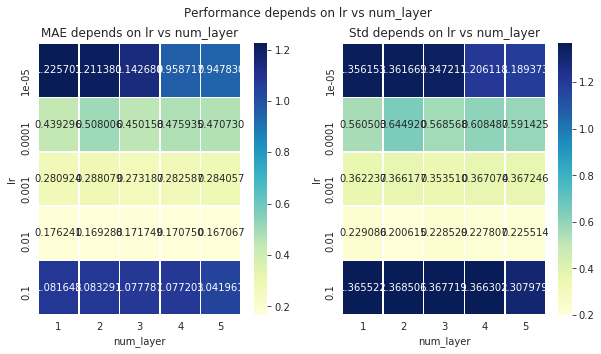

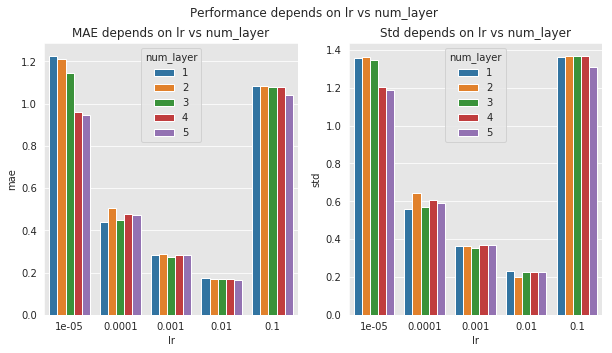

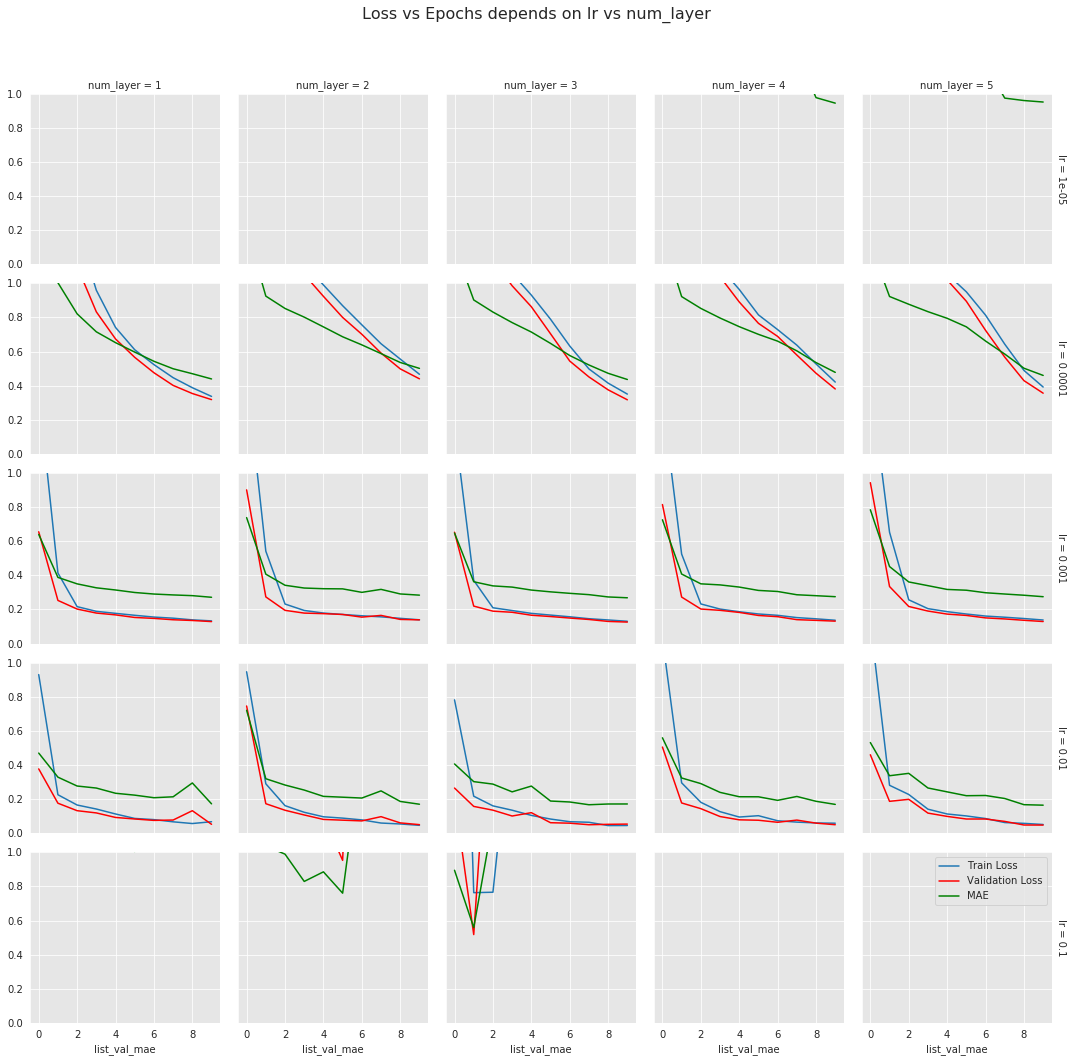

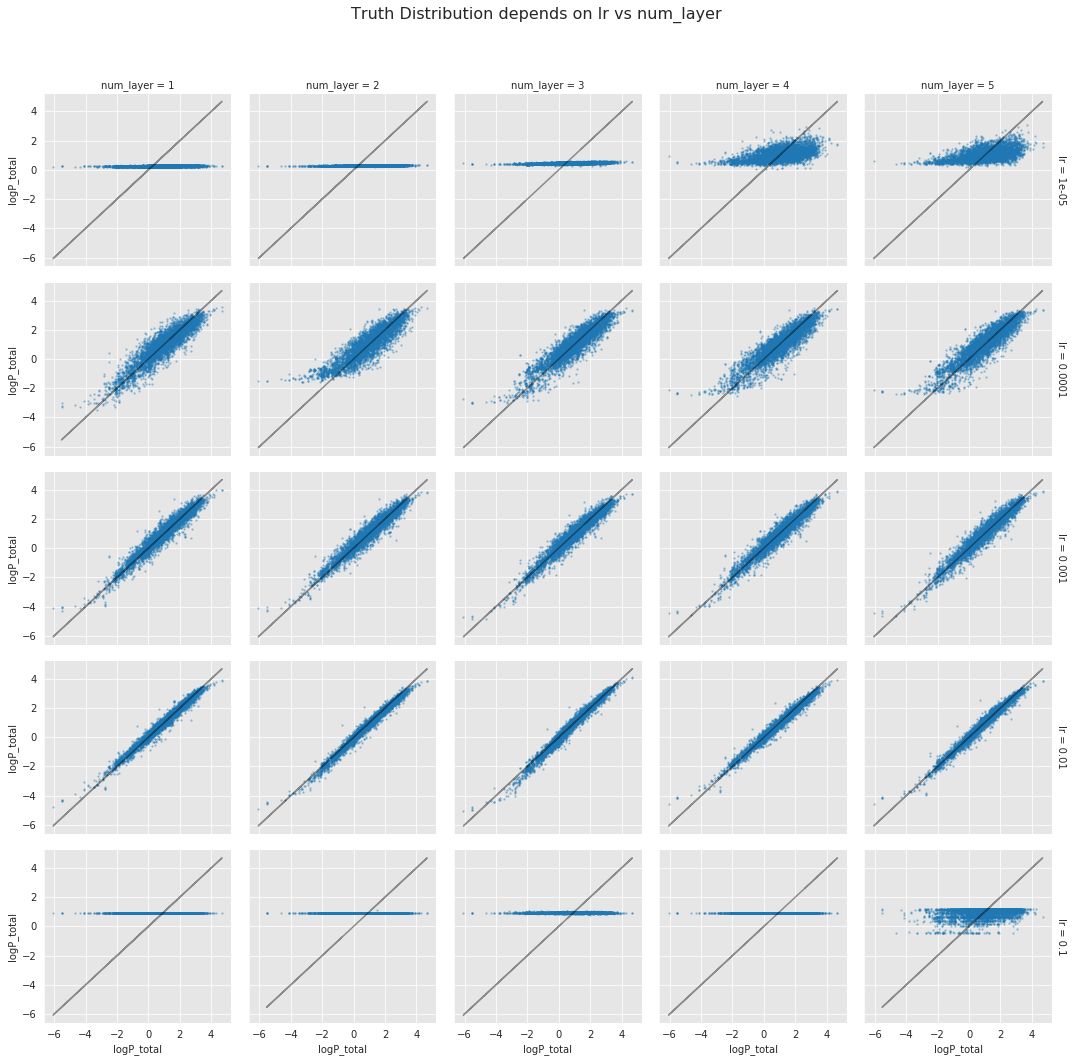

In [98]:
df_result = pd.read_json('lr vs num_layer 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 1)
plot_distribution(df_result, var1, var2)

## Experiment 1. lr vs n_block
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __learning rate (lr)__ and __number of RNN layers (num_layer)__ used in the each block.

The learning rate was chose to be the first hyperparameters to be tuned because if we find the best learning rate, no matter what the model architecture is, we can use that learning rate to future exepriemnts. Thus, the number of block, which effetcs the model architecture the most, was chose to be the second.
#### Variable Domain
- __lr__ : [0.1, 0.01, 0.001, 0.0001, 0.00001]
- __num_layer__ : [1, 2, 3, 4, 5]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule

depending on the two variables.

#### Notable Results
- Learning rate of 0.01 showed the best performance.
- Near the optimal learning rate, model with more layers showed better performance but the difference was negligible.
- For non-optimal learning rate, model with more layers showed better performance notably.

#### Discussion
- Model learned nothing with learning rate of 0.1. This is because the step of opimizer is too big to reach a local minimum.
- The performance difference was large at low learning rate. This is because the total difference of model between each epoch is proportional to both model capacity and the learning rate.

After this experiment, the learning rate and the number of GCN blocks were fixed to 0.01 and 5, which shoed the best performance.

# Experiment 2. step_size vs hidden_dim

In [1]:
args.batch_size = 512
args.lr = 0.01
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 15
args.num_layer = 5
args.dropout = 0
args.in_dim = 32
args.hidden_dim = 64
args.pred_dim1 = 128
args.pred_dim2 = 64
args.out_dim = 1
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

NameError: name 'args' is not defined

In [179]:
list_step_size = [3, 5, 10]
list_hidden_dim = [32, 64, 128, 256]
#list_lr = [0.001]
#list_num_layer = [5]
var1 = "step_size"
var2 = "hidden_dim"

dict_result = dict()
n_iter_train = len(dict_partition['train'])//args.batch_size*args.batch_size
n_iter_val = len(dict_partition['val'])//args.batch_size*args.batch_size
n_iter = len(list_step_size)*len(list_hidden_dim)*args.epoch*(n_iter_train+n_iter_val)
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for step_size in list_step_size:
    for hidden_dim in list_hidden_dim:
        args.step_size = step_size
        args.hidden_dim = hidden_dim
        args.exp_name = var1+':'+str(step_size)+'/'+var2+':'+str(hidden_dim)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('step_size vs hidden_dim 50000.JSON', orient='table')

step_size:3/hidden_dim:32 took 246seconds.
step_size:3/hidden_dim:64 took 284seconds.
step_size:3/hidden_dim:128 took 354seconds.
step_size:3/hidden_dim:256 took 500seconds.
step_size:5/hidden_dim:32 took 247seconds.
step_size:5/hidden_dim:64 took 283seconds.
step_size:5/hidden_dim:128 took 355seconds.
step_size:5/hidden_dim:256 took 501seconds.
step_size:10/hidden_dim:32 took 246seconds.
step_size:10/hidden_dim:64 took 284seconds.
step_size:10/hidden_dim:128 took 354seconds.
step_size:10/hidden_dim:256 took 500seconds.



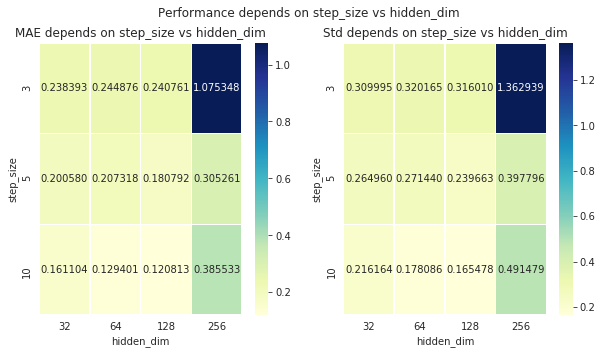

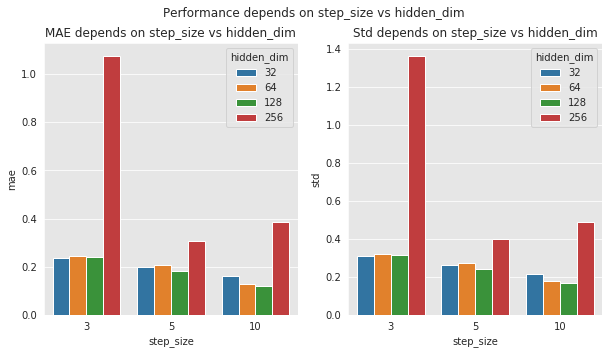

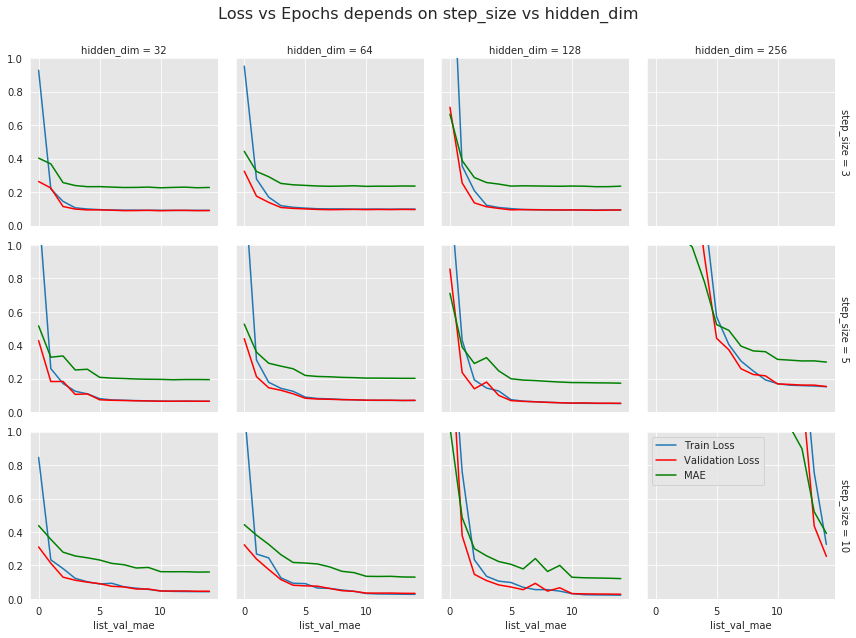

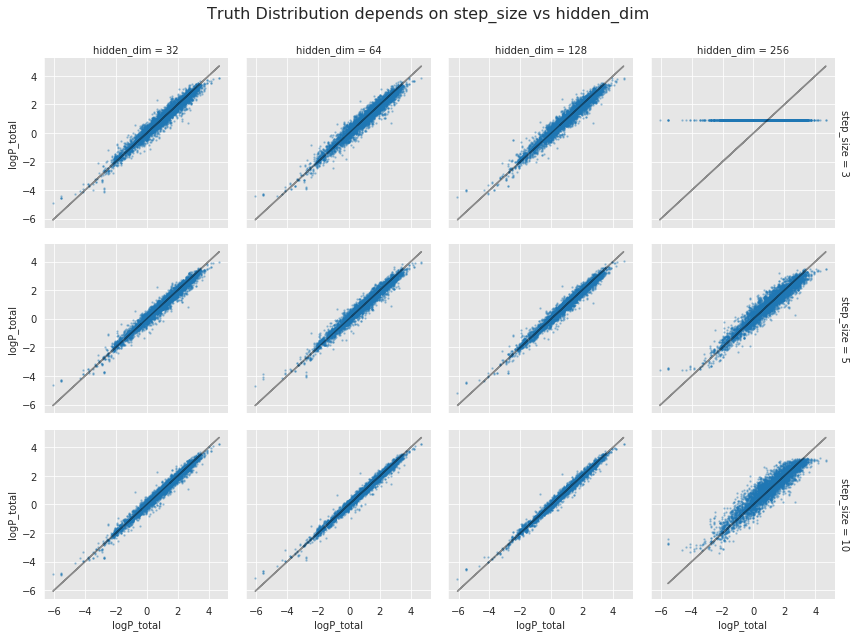

In [108]:
df_result = pd.read_json('step_size vs hidden_dim 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 1)
plot_distribution(df_result, var1, var2)

## Experiment 2. step_size vs hidden_dim
In this experiement, the preformance of regression was measured by the __Mean Absolute Error (MAE)__ and the __Standard Deviation (Std)__, with respect to the different __step size of the learning rate drop (step_size)__ and __hidden dimension (hidden_dim)__ used in the each RNN layer.

The learning rate was chose to be the first hyperparameters to be tuned because if we find the best learning rate, no matter what the model architecture is, we can use that learning rate to future exepriemnts. Thus, the number of block, which effetcs the model architecture the most, was chose to be the second.
#### Variable Domain
- __lr__ : [0.1, 0.01, 0.001, 0.0001, 0.00001]
- __num_layer__ : [1, 2, 3, 4, 5]

### Results and Discussion
Each figure at the top represents:
1. The MAE and std value by heatmap, which shows the exact value of MAE and std.
2. The MAE and std value by bar plot, which shows the tendency of performance depending on the variables.
3. Train loss and validation loss.
4. The distribution true logP value and predicted logP value of each molecule

depending on the two variables.

#### Notable Results
- Learning rate of 0.01 showed the best performance.
- Near the optimal learning rate, model with more layers showed better performance but the difference was negligible.
- For non-optimal learning rate, model with more layers showed better performance notably.

#### Discussion
- Model learned nothing with learning rate of 0.1. This is because the step of opimizer is too big to reach a local minimum.
- The performance difference was large at low learning rate. This is because the total difference of model between each epoch is proportional to both model capacity and the learning rate.

After this experiment, the learning rate and the number of GCN blocks were fixed to 0.01 and 5, which shoed the best performance.

In [69]:
args.batch_size = 512
args.lr = 0.01
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 10
args.cell_type = 'LSTM'
args.num_layer = 5
args.dropout = 0
args.bidirectional = False
args.in_dim = 32
args.hidden_dim = 128
args.pred_dim1 = 128
args.pred_dim2 = 64
args.out_dim = 1
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [70]:
list_pred_dim1 = [32, 64, 128, 512]
list_pred_dim2 = [32, 64, 128, 512]
var1 = "pred_dim1"
var2 = "pred_dim2"

dict_result = dict()
n_iter_train = len(dict_partition['train'])//args.batch_size*args.batch_size
n_iter_val = len(dict_partition['val'])//args.batch_size*args.batch_size
n_iter = len(list_pred_dim1)*len(list_pred_dim2)*args.epoch*(n_iter_train+n_iter_val)
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for pred_dim1 in list_pred_dim1:
    for pred_dim2 in list_pred_dim2:
        args.pred_dim1 = pred_dim1
        args.pred_dim2 = pred_dim2
        args.exp_name = var1+':'+str(pred_dim1)+'/'+var2+':'+str(pred_dim2)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('pred_dim1 vs pred_dim2 50000.JSON', orient='table')

NameError: name 'LSTMBlock' is not defined

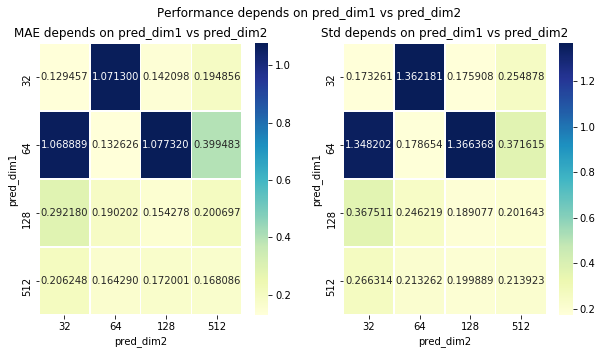

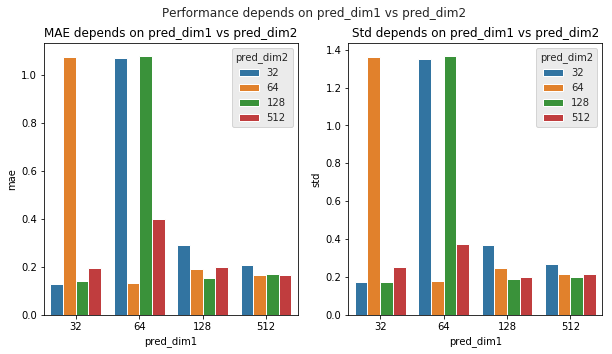

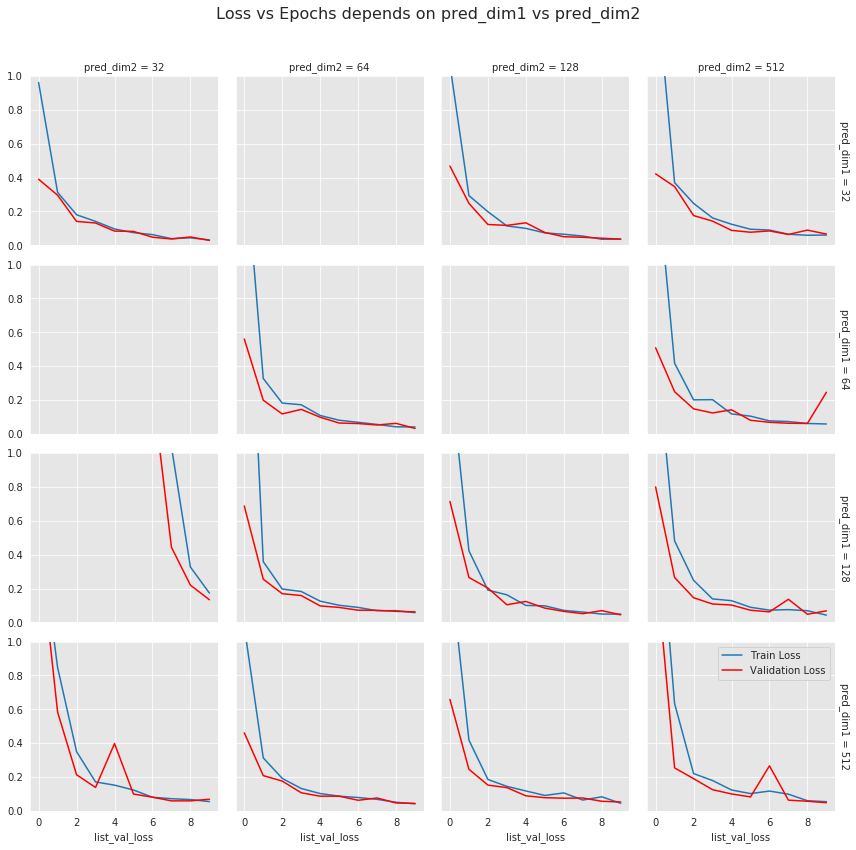

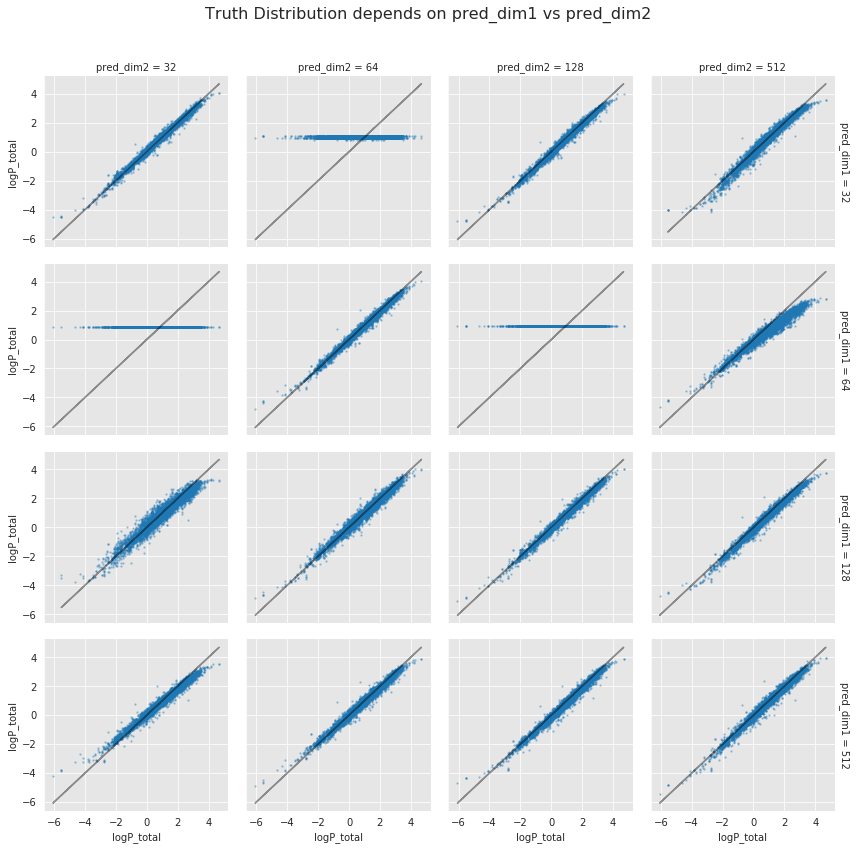

In [25]:
df_result = pd.read_json('pred_dim1 vs pred_dim2 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 1)
plot_distribution(df_result, var1, var2)

In [77]:
args.batch_size = 512
args.lr = 0.01
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 10
args.cell_type = 'LSTM'
args.num_layer = 5
args.dropout = 0
args.bidirectional = False
args.in_dim = 32
args.hidden_dim = 128
args.pred_dim1 = 64
args.pred_dim2 = 64
args.out_dim = 1
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [78]:
list_l2_coef = [0, 0.00001, 0.0001, 0.001, 0.01]
list_dropout = [0, 0.1, 0.2, 0.3, 0.4]
var1 = "l2_coef"
var2 = "dropout"

dict_result = dict()
n_iter_train = len(dict_partition['train'])//args.batch_size*args.batch_size
n_iter_val = len(dict_partition['val'])//args.batch_size*args.batch_size
n_iter = len(list_l2_coef)*len(list_dropout)*args.epoch*(n_iter_train+n_iter_val)
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for l2_coef in list_l2_coef:
    for dropout in list_dropout:
        args.l2_coef = l2_coef
        args.dropout = dropout
        args.exp_name = var1+':'+str(l2_coef)+'/'+var2+':'+str(dropout)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('l2_coef vs dropout 50000.JSON', orient='table')

l2_coef:0/dropout:0 took 236seconds.
l2_coef:0/dropout:0.1 took 242seconds.
l2_coef:0/dropout:0.2 took 242seconds.
l2_coef:0/dropout:0.3 took 242seconds.
l2_coef:0/dropout:0.4 took 242seconds.
l2_coef:1e-05/dropout:0 took 238seconds.
l2_coef:1e-05/dropout:0.1 took 245seconds.
l2_coef:1e-05/dropout:0.2 took 244seconds.
l2_coef:1e-05/dropout:0.3 took 243seconds.
l2_coef:1e-05/dropout:0.4 took 242seconds.
l2_coef:0.0001/dropout:0 took 236seconds.
l2_coef:0.0001/dropout:0.1 took 242seconds.
l2_coef:0.0001/dropout:0.2 took 242seconds.
l2_coef:0.0001/dropout:0.3 took 242seconds.
l2_coef:0.0001/dropout:0.4 took 245seconds.
l2_coef:0.001/dropout:0 took 238seconds.
l2_coef:0.001/dropout:0.1 took 243seconds.
l2_coef:0.001/dropout:0.2 took 242seconds.
l2_coef:0.001/dropout:0.3 took 242seconds.
l2_coef:0.001/dropout:0.4 took 243seconds.
l2_coef:0.01/dropout:0 took 236seconds.
l2_coef:0.01/dropout:0.1 took 242seconds.
l2_coef:0.01/dropout:0.2 took 242seconds.
l2_coef:0.01/dropout:0.3 took 243second

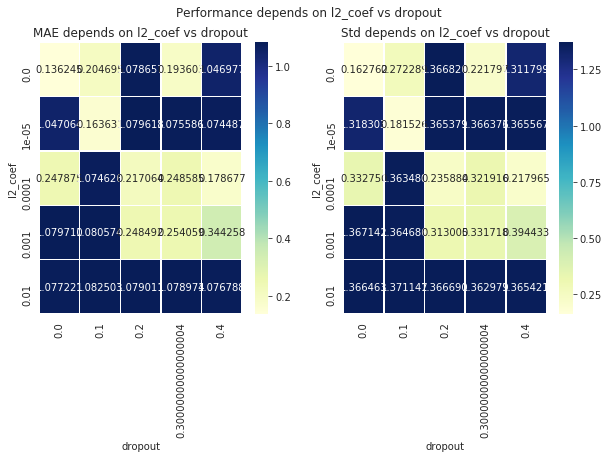

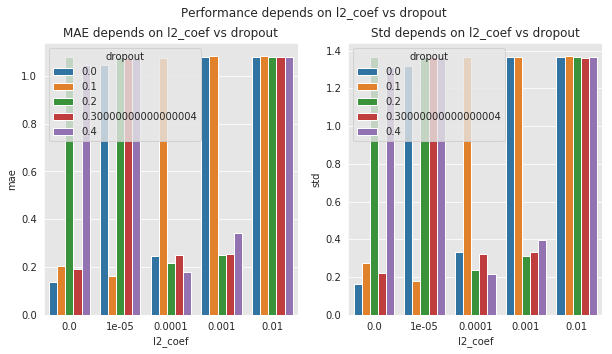

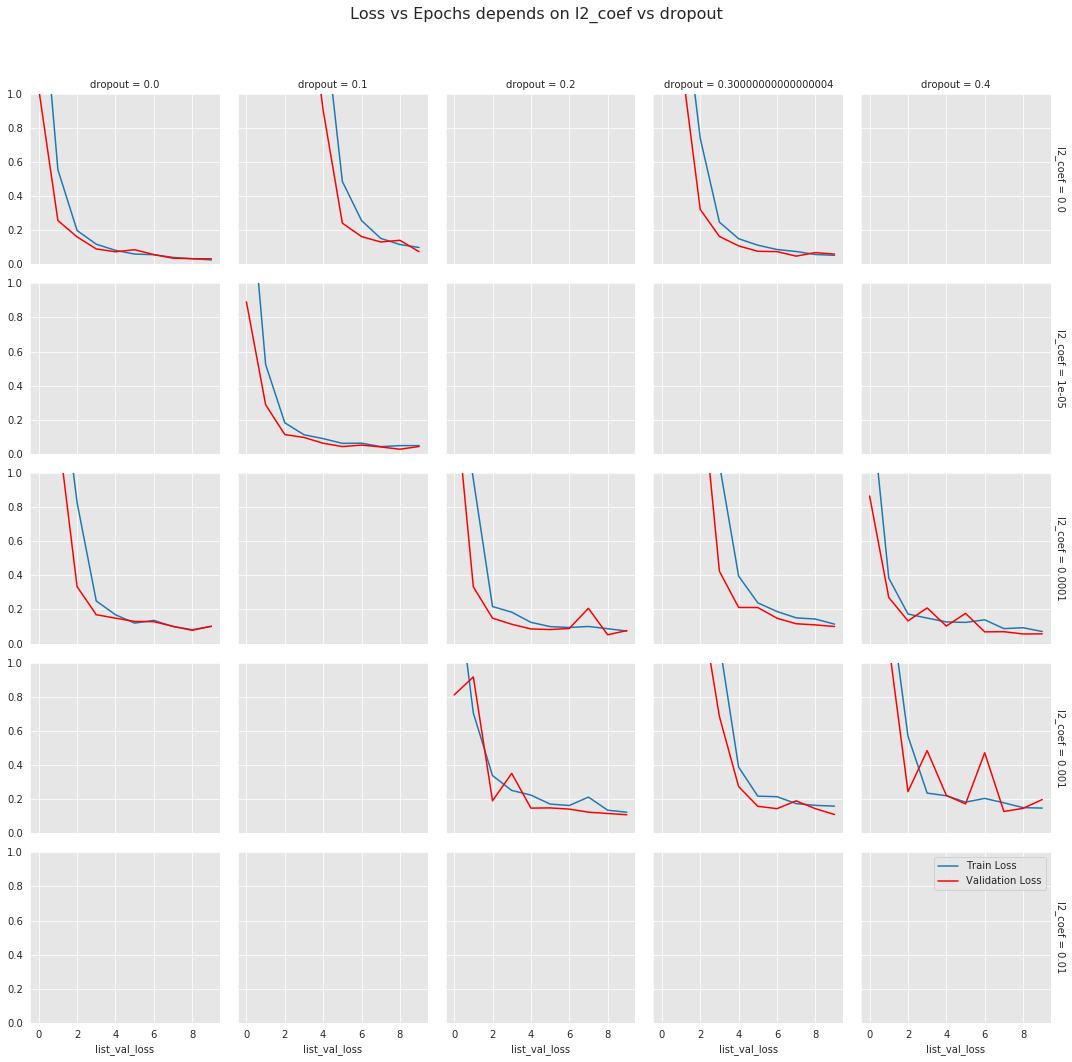

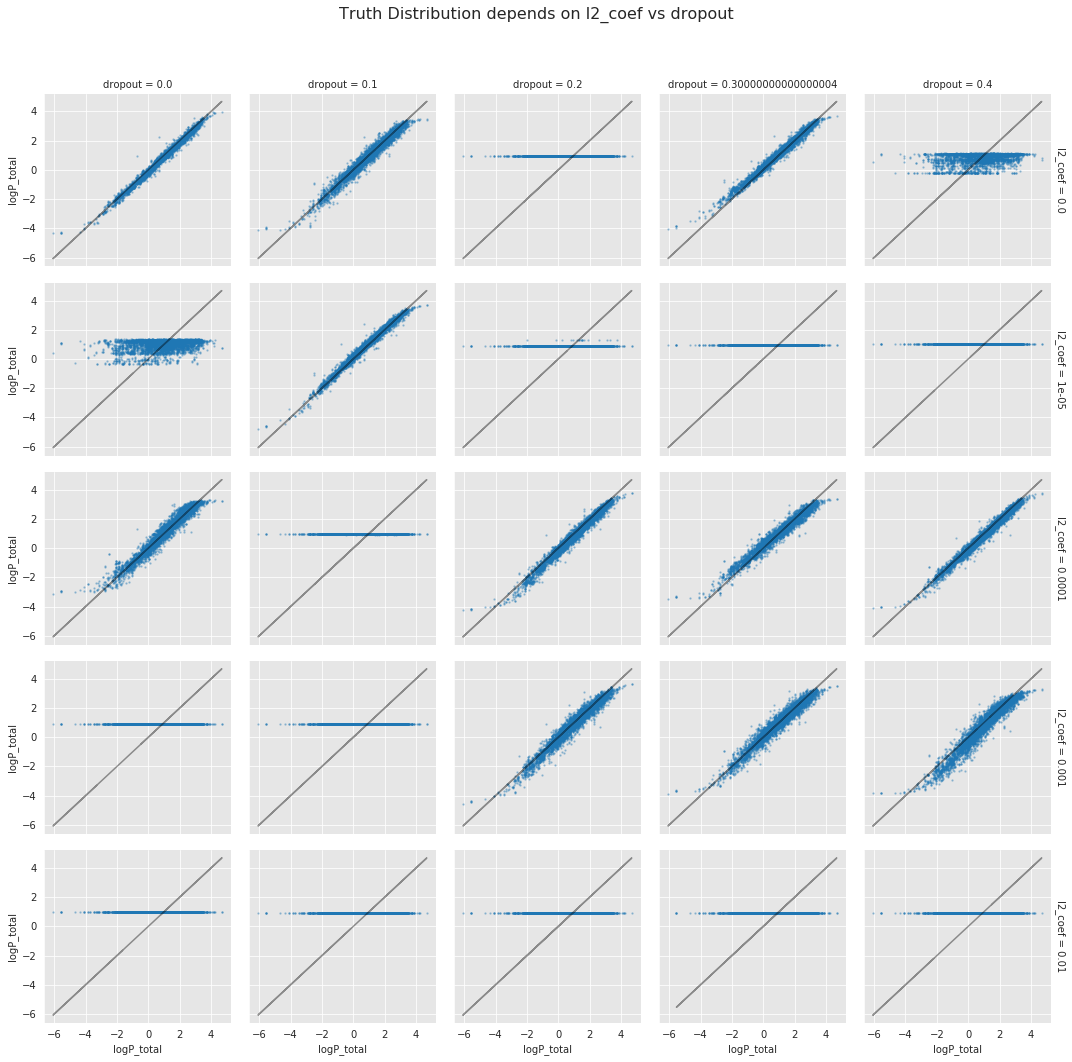

In [79]:
df_result = pd.read_json('l2_coef vs dropout 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 1)
plot_distribution(df_result, var1, var2)

In [83]:
args.batch_size = 512
args.lr = 0.01
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 10
args.cell_type = 'LSTM'
args.num_layer = 5
args.dropout = 0
args.bidirectional = False
args.in_dim = 32
args.hidden_dim = 128
args.pred_dim1 = 64
args.pred_dim2 = 64
args.out_dim = 1
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [84]:
list_cell_type = ['LSTM', 'GRU']
list_bidirectional = [True, False]
var1 = "cell_type"
var2 = "bidirectional"

dict_result = dict()
n_iter_train = len(dict_partition['train'])//args.batch_size*args.batch_size
n_iter_val = len(dict_partition['val'])//args.batch_size*args.batch_size
n_iter = len(list_cell_type)*len(list_bidirectional)*args.epoch*(n_iter_train+n_iter_val)
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for cell_type in list_cell_type:
    for bidirectional in list_bidirectional:
        args.cell_type = cell_type
        args.bidirectional = bidirectional
        args.exp_name = var1+':'+str(cell_type)+'/'+var2+':'+str(bidirectional)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('cell_type vs bidirectional 50000.JSON', orient='table')

cell_type:LSTM/bidirectional:True took 373seconds.
cell_type:LSTM/bidirectional:False took 236seconds.
cell_type:GRU/bidirectional:True took 373seconds.
cell_type:GRU/bidirectional:False took 234seconds.



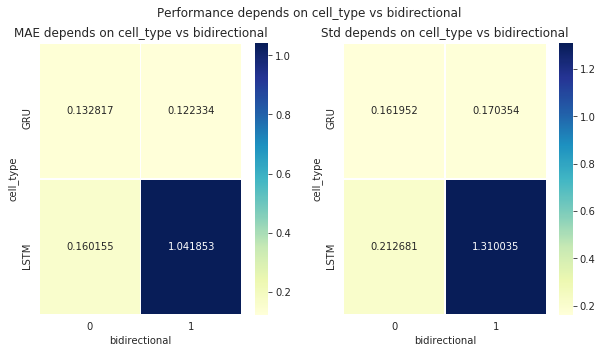

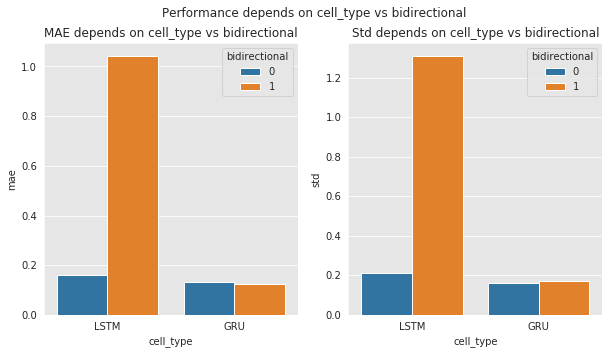

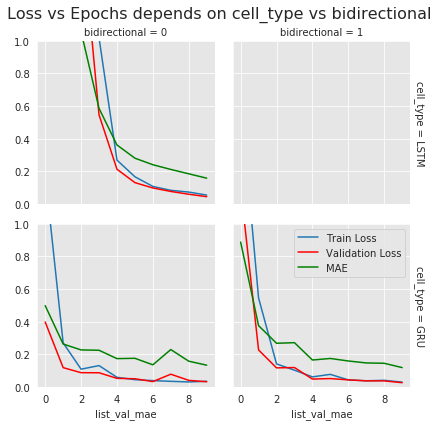

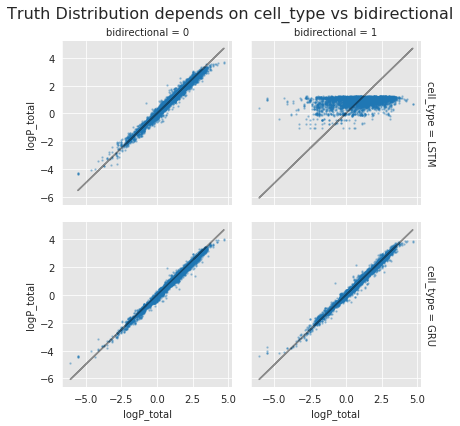

In [95]:
df_result = pd.read_json('cell_type vs bidirectional 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 1)
plot_distribution(df_result, var1, var2)

In [86]:
list_smiles, list_logP = read_ZINC_smiles("ZINC.smiles", 190000)
list_onehot, list_length = smiles_to_onehot(list_smiles)
dict_partition = partition(list_onehot, list_length, list_logP, args)

In [87]:
args.batch_size = 512
args.lr = 0.01
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 50
args.cell_type = 'GRU'
args.num_layer = 5
args.dropout = 0
args.bidirectional = True
args.in_dim = 32
args.hidden_dim = 128
args.pred_dim1 = 64
args.pred_dim2 = 64
args.out_dim = 1
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [88]:
dict_result = dict()
n_iter_train = len(dict_partition['train'])//args.batch_size*args.batch_size
n_iter_val = len(dict_partition['val'])//args.batch_size*args.batch_size
n_iter = args.epoch*(n_iter_train+n_iter_val)
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

args.exp_name = "result 190000"
result = vars(experiment(dict_partition, device, bar, args))
dict_result[args.exp_name] = copy.deepcopy(result)

torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('result 190000.JSON', orient='table')

MAE: 0.0415632222
Std: 0.0664389704


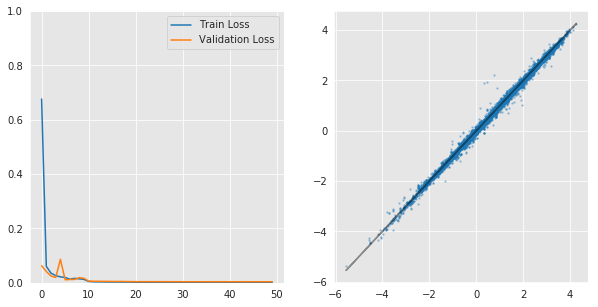

In [89]:
df_result = pd.read_json('result 190000.JSON', orient='table')

print("MAE: " + str(df_result['mae'][0]))
print("Std: " + str(df_result['std'][0]))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

ax[0].plot(df_result['list_train_loss'][0], label='Train Loss')
ax[0].plot(df_result['list_val_loss'][0], label='Validation Loss')
ax[0].set_ylim([0, 1])
ax[0].legend()
ax[1].scatter(df_result['logP_total'][0], df_result['pred_logP_total'][0], alpha=0.3, s=2)
ax[1].plot(df_result['logP_total'][0], df_result['logP_total'][0], color='black', alpha=0.4)